# Loading the graph

First, we load the model from the estimator checkpoint. The checkpoint is actually not enough information to load the model by itself. Checkpoints are code-dependent. We need to add some code to our estimator to write the graph using the SavedModel api instead.

Because of that, and other limitations, we ended up abandoning the Estimator API and use a MonitoredTrainingSession object instead. We just put in a saving hook. What we need to extract now is the decoder and encoder.

In [2]:
import numpy as np
import tensorflow as tf
import afqstensorutils as atu

In [4]:
graph = tf.Graph()
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)
loc = "training_water/Classifying_1,5,6,12,sigmoid/"
saver = tf.train.import_meta_graph(loc+'final_graph.meta')
saver.restore(sess,loc+'final_variables.ckpt')
i_q =graph.get_tensor_by_name('i_q:0') 
o_x =graph.get_tensor_by_name('decode:0')

INFO:tensorflow:Restoring parameters from training_water/Classifying_1,5,6,12,sigmoid/final_variables.ckpt


We need to freeze the graph, make operations for the descaling on the front end of the encoder and backend of the decoder.

In [5]:
o_x.eval(feed_dict={i_q:[[0.0,0.0]]})

array([[-0.02329919,  0.00481312, -0.01067008,  0.00607748]],
      dtype=float32)

In [10]:
scale = np.loadtxt('surf_ranges.csv',skiprows=1,delimiter=',')

In [22]:
def unshift(x, scale):
    return (scale[2,:]-scale[1,:])*x + scale[0,:]
def shift(x,scale):
    return (x-scale[0,:])/(scale[2,:]-scale[1,:])

In [23]:
o_s = unshift(o_x,scale[:,0:4])

In [24]:
o_s.eval(feed_dict={i_q:[[0.0,0.0]]})

array([[4.2578339e+02, 5.0161962e+05, 4.2523779e+02, 1.7693838e+06]],
      dtype=float32)

# Building the DAE

In [60]:
p_inf = tf.constant( 6.0e5)
T_inf = tf.constant( 300.0)
Dt = tf.constant(1.0)
haii = 1.0

## The Physics.

In [102]:
def m_and_r(x):
#     x = au.decode(q)
    T,p,rho,h=tf.split(x,4,axis=-1)
    m = tf.concat([rho,rho*h],axis=-1)
#     rate = tf.concat([1.0*(p_inf-p), 0.0*(T_inf-T)],axis=-1)
    rate = tf.concat([0*p, 0*T-5.0e6],axis=-1)
    return m,rate

In [103]:
m_i,r_i = m_and_r(o_s)
lhs = m_i - Dt*haii*r_i
rhs = m_i + (1.0-haii)*Dt*r_i
K = atu.vector_gradient(lhs,i_q)

In [104]:
r_i.eval(feed_dict={i_q:q_0})
m_i.eval(feed_dict={i_q:q_0})

array([[-9.545439e+07, -5.253536e+18]], dtype=float32)

In [105]:
q_i = np.array([[0.0,0.0]])
q_0 = np.array([[0.0,0.0]])
series_q = []
series_s = []
for it in range(100):
    rhs_0 = sess.run(rhs,feed_dict={i_q:q_0})
    for k in range(10):
        K_k,lhs_k = sess.run([K,lhs],feed_dict={i_q:q_i})
        R = rhs_0 - lhs_k
        Dq = np.linalg.solve(K_k[0,:,:],R[0,:])
        q_i[:] += Dq
        n = np.linalg.norm(Dq)
        if n<1.0e-7: break
    print k,n
    q_0[:]=q_i[:]
    series_q.append(q_0[0,:])
    series_s.append(sess.run(o_s,feed_dict={i_q:q_0})[0,:])
series_q = np.array(series_q)
series_s = np.array(series_s)

9 4.429105e-07
3 0.0
9 3.2705728e-07
3 0.0
3 0.0
4 0.0
3 9.285492e-08
3 0.0
4 7.439831e-08
9 1.4261344e-07
4 0.0
3 0.0
3 0.0
3 0.0
5 5.0683227e-08
5 0.0
3 0.0
3 9.0735746e-08
3 8.7763596e-08
3 0.0
4 0.0
4 0.0
4 0.0
3 7.785718e-08
3 0.0
3 7.542822e-08
3 0.0
4 0.0
3 0.0
4 7.2093336e-08
4 7.14891e-08
3 4.553087e-08
3 9.9662486e-08
3 3.633539e-08
3 6.393233e-08
2 4.52847e-08
2 6.907864e-08
3 4.543411e-08
2 4.556359e-08
9 1.3680827e-07
3 9.1832376e-08
2 0.0
5 7.682766e-08
3 5.347459e-08
2 3.9270446e-08
3 9.009543e-08
2 2.3768633e-08
2 2.4602418e-08
3 1.8318364e-08
2 8.969521e-08
9 0.0
2 8.379326e-08
6 4.966873e-08
4 8.468049e-08
2 2.5219622e-08
2 5.083166e-08
3 3.517981e-08
5 1.9684915e-08
5 2.6015297e-08
5 7.679502e-08
2 7.9266236e-08
3 1.7858765e-08
4 5.7383136e-08
6 6.110664e-08
2 2.3039357e-08
3 2.7456556e-08
4 9.401775e-08
2 6.097072e-08
3 0.0
3 2.8796244e-08
3 4.2266514e-08
2 6.185832e-08
3 9.637283e-08
3 5.0191268e-08
5 2.737618e-08
2 2.3252406e-08
9 9.7321085e-08
2 4.792711e-08
6 3.

## Plot the results

In [106]:
from matplotlib import pylab as plt
%matplotlib inline

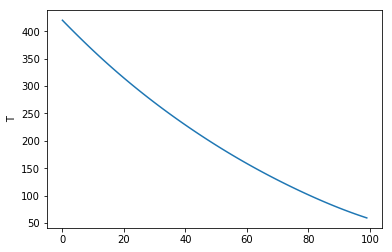

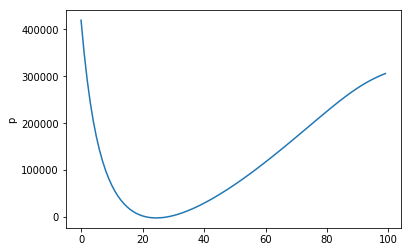

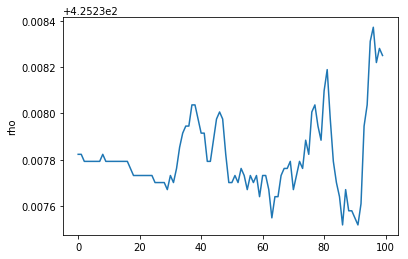

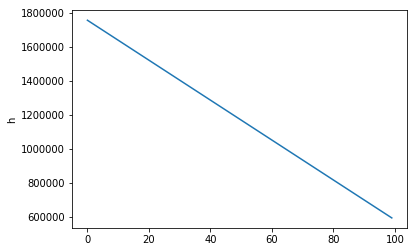

In [107]:
legends=['T','p','rho','h']
for i,name in enumerate(legends):
    plt.figure()
    plt.plot(series_s[:,i])
    plt.ylabel(name)